# Optimisation Problem: Transmission Power Control 

# Projected Gradient Method  and Topology Consensus in a Behaviour Tree Architecture


![radiocontrol_whiteboard.jpg.svg](attachment:radiocontrol_whiteboard.jpg.svg)



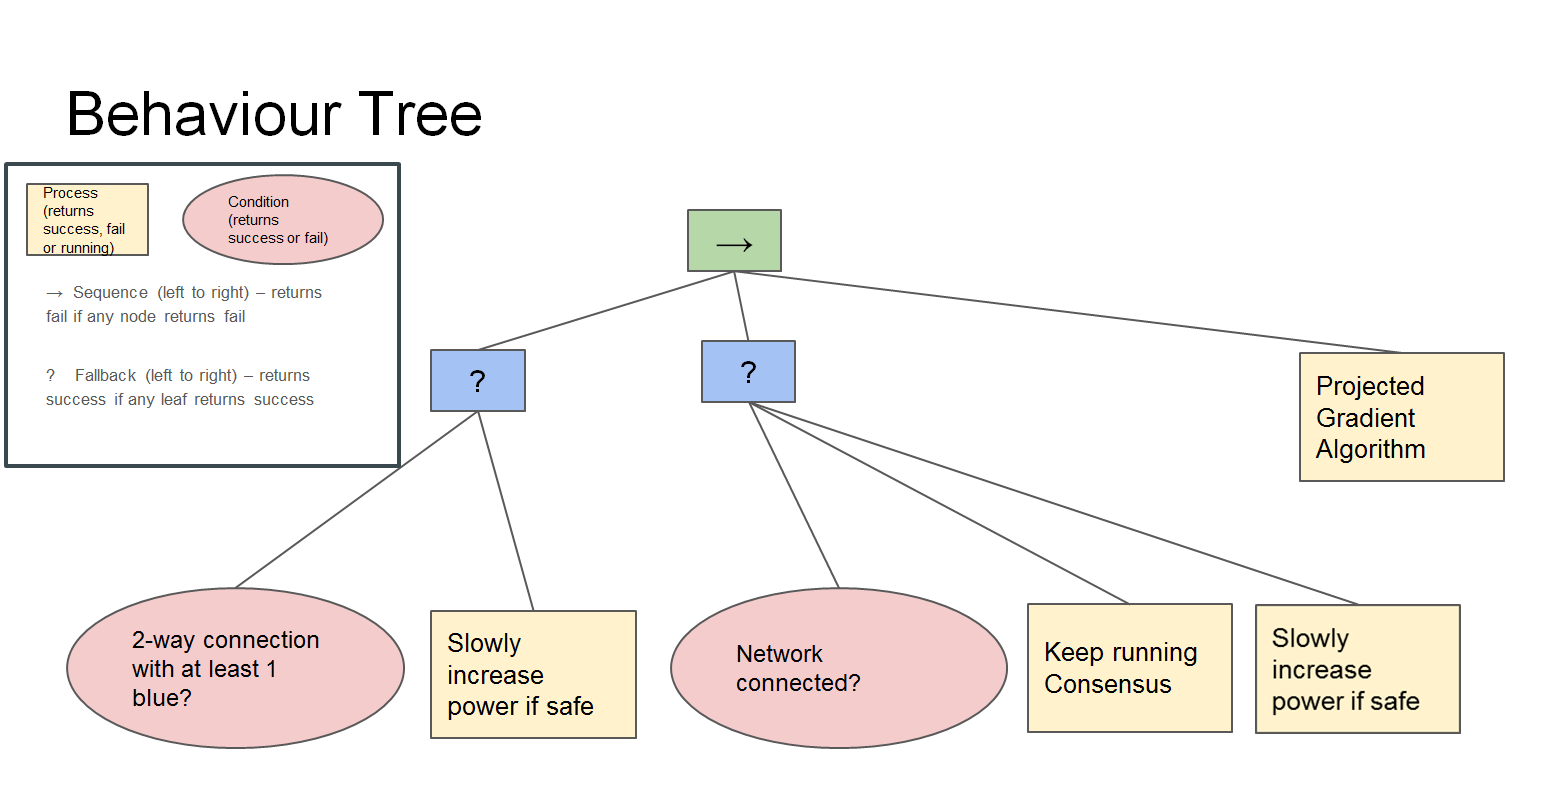

In this method we consider the full behaviour of distributed agents without assuming they are connected from the initial time.

### Assumption 1 
We do assume that initially total number of agents is known by each agent. Agents transmitting messages with an initial power level which either result in 2-way connections between them or not.

## Increase Power Block 
Hence we need to add a behaviour that gradually increases the transmission power (if safe with respect to the local knowledge of enemy vehicle locations) until at least one 2-way conncetion is achieved. This will enable the following behaiour or will fail until the enemy configuration is changed, if at all.

### Assumption 2
Here we won't consider the hopeless situation where a 2-way conncetion is continuously not attained while increasing the power is continuously not safe.  

## Gossip (Consensus) Block
Once at least one connection is achieved the agent needs to run a consensus algorithm to find out if the extended network enabled by its neighbours includes all the agents in the fleet, i.e. is connected. After the algorithm converges, and if still the network is not connected the agent will further increase it's transmission power (if safe with respect to the estimate semi global enemy information).

### Assumption 3
Again we won't consider the hopeless situation where a connected network is never attained.

Now the agent has a connected network we will attempt optimising transmission power such that its connectivity is maintained and its signature is minimised with respect to the changing enemy locations (which it has an estimate for based on its consensus algorithm).

## Behaviour Tree
At any point, if the connectivity is lost based on the optimised decisions the behaviour needs to revert back to its previous safe connectivity build up behaviours. 


We will put these behaviours together in a Behaviour Tree architecture. For a good reference on behaviour trees and the symbology of the model please refer to: Colledanchise, Michele, and Petter Ögren. "Behavior Trees in Robotics and AI, an Introduction." https://arxiv.org/pdf/1709.00084.pdf


The picture attached above includes the behaviour tree for the combined design as was explained before. The ellipse leaf nodes are conditions that return either success or faliour. The box leaf nodes are durative actions/algorithms that either return running (if they have not converged), success or failure. These responses need to be carefully and logically defined. The question-mark parent nodes of the tree are fallback blocks. The parent nodes continually tick their child nodes from left to right. The fallback parent will return success or running as soon as one child returns success or running and it will return failure if all childs return failure. The arrow parent box is a sequence block and will return failure/running as soon as one child returns failure/running and returns success if all childs return success.

Sequence node implementation code can be seen in : 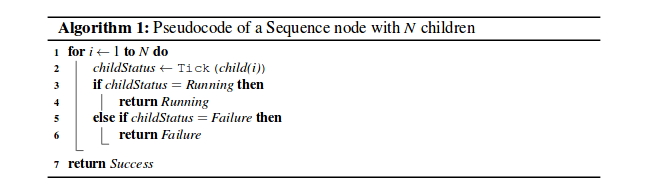

Fallback node implementation code can be seen in : 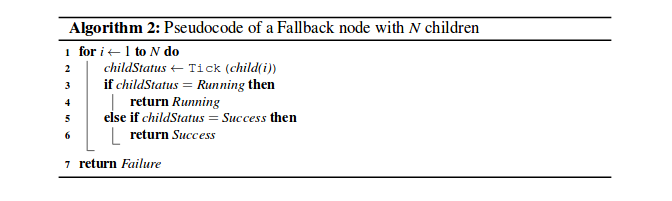

## Optimisation Block
The Optimisation problem is defined as in the equations of the picture above. In the following we formalise that.
The diagram below is used to explain the assumptions.


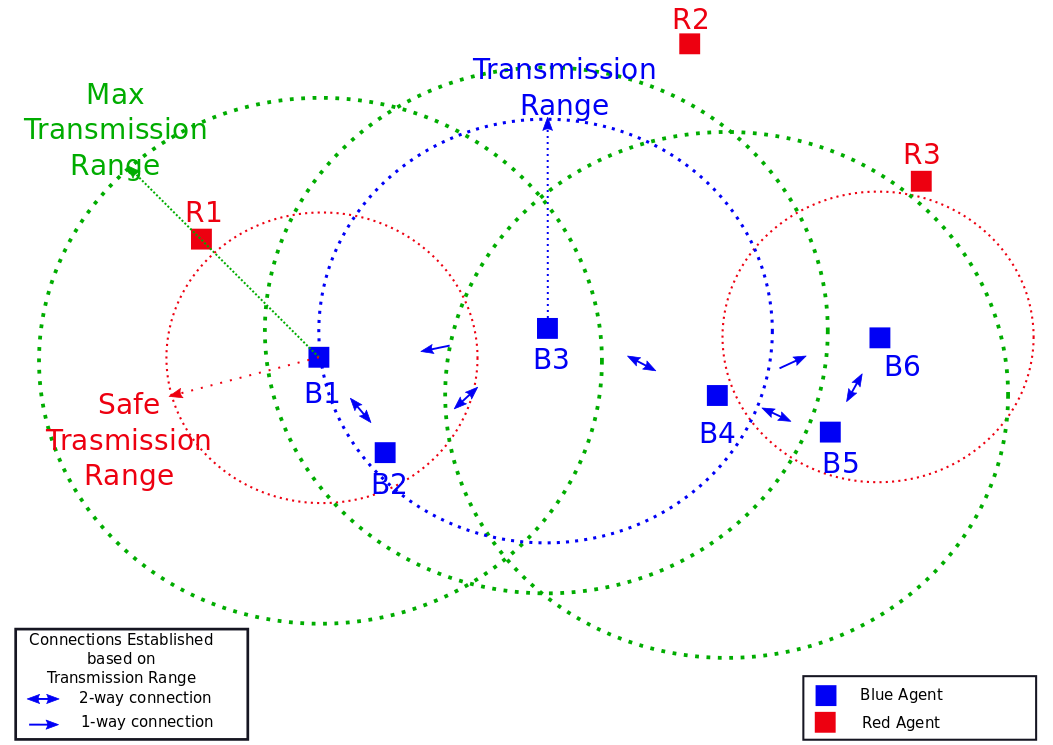

### Assumption 4:
Note that the previous assumptions imply that the optimisation block starts with a connected network topology. The additional assumption here is that red vehicle position variations are such that a connected modified network topology based on the previous step connected network topology is possible, i.e. the optimisation problem below stays feasible. Note that, this assumption is only used for continuing with the bevaviour defined in this block. If this assumption is violated the beviour tree shall revert back to the previous behaviours invoking the previous assumptions for existance of an alternative connected network toplogy. 


### Constraints
The connectivity constraints for vehicles $i$ with transmission power at $P_i$ at 2D coordinates $l_{i}$ with respect to blue vehicles $j$ in the desired neighbours set $\mathcal{N}_i$ that are located at coordinates $l_j$ is   

\begin{equation}
\begin{split}
 &P_i \geq \mbox{max}_{j\in\mathcal{N}_i} \bigg(\alpha\Vert l_i - l_j \Vert^2 \bigg)\\
 &P_i \leq P^m_i,
 \end{split}
\end{equation}

where $P^{m}_i$ is the maximum transmission power that node $i$ can do and $\alpha$ (here is equal to $1$) is modelling constant that relates transmission power to square distance of nodes in RF models. One choice for $P^{m}_i$ is the maximum distance covers all agents not just the neighbours (we use this in the simulations). 

 Similarly the undetectibility constraint for vehicle $i$ with respect to enemy locations $l_e$ of the enemy set $\mathcal{E}_i$ is

\begin{equation}
\sum_i \frac{P_i}{\Vert l_i - l_e \Vert^2} \leq P_d  
\end{equation}
where $P_d$ is a detection threshold meaning signal levels above this threshold expose signature of blue vehicles to red vehicle $e$. A distributed but more conservative version of this condition can be considered as 

\begin{equation}
P_i \leq  P^s_i ,     
\end{equation}

where $P^s_i = \mbox{min}_{e\in\mathcal{E}_i}\bigg(\alpha\Vert l_i - l_e \Vert^2\bigg)$ is the minimum safe transmission power that node $i$ can do with respect to the red vehicles in it's vicinity.

###  Assumption 5:   
There is no red vehicle $e$ that $e\not\in\mathcal{E}_i$ and $\alpha\Vert l_i - l_e \Vert^2 \leq P_i^m$. That is, if there is an enemy vehicle nearby, the vehicle should know about it. 

### Objective
The objective is to maximise the transmission power of vehicle $i$ up to the maximum transmission power allowed. Alternatively, this means minimising the distance squared to max transmission power. 
\begin{equation}
 \max_{\{P_i\}} -\frac{1}{2}(P_i - P_i^m)^2 = \min_{\{P_i\}} \frac{1}{2}(P_i - P_i^m)^2 
\end{equation}




### Projected Gradient Algorithm
The projected gradient proposes the following iteration step without having to solve an entire optimisation problem everytime the enemy vehicles move.

\begin{equation}
P_i(t+1) = \mathbb{P}( P_i(t) - \gamma \nabla f(P_i)),
\end{equation}
where the gradient step $\gamma$ is a small tunning value. From the theoretical results of the CDC paper this value needs to be chosen carefully in order to satisfy the convergence properties.
The mapping $\mathbb{P}(.):\mathbb{R}\longrightarrow \mathcal{S}$ is a projection operator from the reals to the feasible states set $\mathcal{S}_i$ (i.e. the set of $P_i$ values that satisfy all the constraints above).  
The contraints mentioned above boil down to one dimentional bounded set constraint 

\begin{equation}
\mathcal{S}_i = \{P_i :\mbox{min}(P_s,\mbox{max}_{j\in\mathcal{N}_i} \bigg(\alpha\Vert l_i - l_j \Vert^2 \bigg))\leq P_i \leq \min (P_i^m,\;P^s_i) \},
\end{equation}
where recall that $P^s_i = \mbox{min}_{e\in\mathcal{E}_i}\bigg(\alpha\Vert l_i - l_e \Vert^2\bigg)$. Note that in above if the problem is challgenging and $P_s$ is less than both $P_m$ and distance squared needed to cover the neighbours, the $P_i = P_s$ is the only feasible solution.

The associated projection operator is then defined as
\begin{equation}
\mathbb{P}(X) = \mbox{min}\bigg[\min (P_i^m,\;P^s_i), \mbox{max}\big[X,\mbox{min}\bigg(P_s,\mbox{max}_{j\in\mathcal{N}_i} \big(\alpha\Vert l_i - l_j \Vert^2 \big)\bigg)\big]\bigg].
\end{equation}

The gradient of the objective function above is simply 
\begin{equation}
\nabla f(P_i) =  (P_i - P_i^m)
\end{equation}

Therefore, the projected gradient iteration of solution takes the following form. 

\begin{equation}
P_i(t+1) = \mbox{min}\bigg[\min (P_i^m,\;P^s_i), \mbox{max}\bigg( P_i(t) - \gamma (P_i(t)-P_i^m),\mbox{min}\big(P_s,\mbox{max}_{j\in\mathcal{N}_i} \big(\alpha\Vert l_i - l_j \Vert^2 \big)\big)\bigg)\bigg]
\end{equation}

Next we simulate the aformentioned behaviour tree using a numerical example. 





In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 

# from matplotlib import animation
from matplotlib import animation, rc
from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"


# from IPython.display import HTML

# a lib for network generation and other operations
import networkx as nx

# import random
import time

from mesa.space import MultiGrid
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector



import cvxpy as cp



In [ ]:
# the garadient method
# we write the controller in a function form so that we can easily reuse the code later on

def proj_grad_power_control(l_i, P_p, l_b_list, l_n_list, l_e_list):
    #start of timer
    start = time.clock()
    
    # create the decision variable P or the transmission power of vehicle i
       
    alpha = 1 # \alpha_b=\alpha_e=\alpha = 1 this is an arbitrary choice later on should be adjusted from the actual models
    gamma = .5 # this should be small enough for guaranteeing the convergence and bounding regret of the method
    
    
    iteration = 1
    
    
    # P_m  is the max distance that covers all the blue vehicles 
    P_m = np.max(np.linalg.norm(l_b_list - l_i, axis=1, keepdims=True))**2/alpha

    # P_s  is the min distance that does not cover any red vehicles
    P_s = np.min(np.linalg.norm(l_e_list - l_i, axis=1, keepdims=True))**2/alpha -.01
    
#     # P_c is the distance that covers at least one successor vehicles
#     P_c = np.min(np.linalg.norm(l_n_list - l_i, axis=1, keepdims=True))**2/alpha
    
#     if (P_c > P_s):
#         print ("Infeasible problem for PG power set to min safe")
#         return P_s  

    # P_c is the distance that cover all successor vehicles
    # note that in a difficult situation where P_s < P_c the projected gradient will correctly
    # return P_n = P_s 
    P_c = 0
    # this checks if the list is not empty
    if l_n_list:
        P_c = np.max(np.linalg.norm(l_n_list - l_i, axis=1, keepdims=True))**2/alpha   
        
    
    
    # new power
    for i in range(iteration):
        P_n = np.min([np.min([P_m, P_s]), np.max([P_p - gamma * (P_p - P_m), P_c] )] )
    
    elapsed = (time.clock() - start)
    print ("time elapsed for gradient algorithm", elapsed)
    return (P_n)




In [ ]:
# # this method is a mini optimisation that determines the a feasible placement of the random red nodes previously generated
# def red_feasible (pos_red, pos_blue): 
    
    
    
    
    
#     alpha = 1
#     # min distance between red and blue
#     d_min = 1
    
#     # for each red vehicle
#     for r in pos_red.keys():
        
#         # Construct the problem.
#         x = cp.Variable(2)
        
#         objective = cp.Minimize(cp.norm(x - np.array(pos_red[r]))**2 + .10* sum (cp.norm(x - np.array(pos_blue[b]))**2 for b in pos_blue.keys()))
        
#         constraints = []
#         for b in pos_blue.keys():
#             constraints.append(x - np.array(pos_blue[b]) > [.5,.5])
# #         constraints = [sum(x - np.array(pos_blue[b]) for b in pos_blue.keys()) >[5, 5]]
    
#         prob = cp.Problem(objective, constraints)
#         prob.solve()

#         # The optimal objective value is returned by `prob.solve()`.
#         pos_red[r] = x.value
#     return pos_red

In [ ]:
# colors the links blue if the transmission power is chosen correctly
def color_links (G_blue, P_p_list):
    
   
    alpha = 1
    
    # for each blue vehicle 
    for b in G_blue.nodes():
        
        
    
        # figure out the position of that vehicle,
        l_i = pos_blue[b]

        
    
        # figure out the list of neighbours that that vehicle needs to have (according to the network graph)
        neigh = G_blue.successors(b)
        
      
        for nei in neigh:
        
            if (P_p_list[b] >= np.linalg.norm(pos_blue[nei] - l_i)**2/alpha):
                G_blue.out_edges[b,nei]['color']="blue"
                
            else:
                G_blue.out_edges[b,nei]['color']="black"    
           
        
    edges = G_blue.edges()
    
    # the colors of edges with the default colors
    colors = [G_blue[u][v]['color'] for u,v in edges]
    
    # return the color list of each like    
    return colors    
        

In [ ]:
# this method gradually increases the transmission power if it is safe to do so based on enemy locations
def ramp_power (power, l_i, l_e_list ):
    
    output = {'status': "Failure", 'power': power}
    
    alpha = 1
    # power ramp rate
    delta = .1
    # power ramp bias
    beta = .01
    
    # P_s  is the min power that does not cover any red vehicles
    P_s = np.min(np.linalg.norm(l_e_list - l_i, axis=1, keepdims=True))**2/alpha -.01
    
    if (output['power'] > P_s):
        output['power'] = P_s
        return output
    
    if (output['power'] + beta + output['power'] * delta < P_s ):
        
        output['power'] = output['power'] + beta + output['power'] * delta
        output['status'] = 'Success'
        
        return output
        
    
    return output
    
    

In [ ]:
##TODO
# this method determines for agent  i whether it has at least one 2-way conncetion with any agent
def local_connection(agent_id, G_blue_estimate):
    
    # initialise with default output
    output= {'status' : "Failure"}
    
#     size = np.shape(G_blue_estimate)[0]
    
    # The agents that send info to this agent
    senders = G_blue_estimate.predecessors(agent_id)
    
    for s in senders:
        # if this agent also sends information to at least one sender
        if (G_blue_estimate.has_edge(agent_id,s)):
            output['status'] = "Success"
            print ("a 2-way connection exists for agent: ", agent_id)
            return output
            
    
#     for i in range(size):     
#         if ((i != agent_id) and G_blue_estimate[agent_id,i] == 1 and G_blue_estimate[i,agent_id] == 1):
            
            
    
    
    return output

In [ ]:
## TODO needs chekcing in terms of mutabality of network graph, creating a new one based on old one and the scipy
## format of the adjecency
# this method updates agent's topology estimate both based on comms actually received and the laplacian in that comms
def update_topology (b_id, model, G_blue_estimate, G_blue_estimate_time):
    
    output = {'status' : "Failure", 'topology':G_blue_estimate, 'topology_time':G_blue_estimate_time }
    
    #1- update topology by adding a link from the agent sending messages (if doesn't already exist )
    senders = model.topology_blue.predecessors(b_id)
    
    # also update topology estimate also by deleting a link from the agent sending messages (if doesn't exist anymore)
    past_senders = [ps for ps in G_blue_estimate.predecessors(b_id)]    
    
    for p_s in past_senders:
        if (not model.topology_blue.has_edge(p_s,b_id) and G_blue_estimate.has_edge(p_s,b_id)):
            G_blue_estimate.remove_edge(p_s, b_id)    
    
    for s in senders:
        if (not G_blue_estimate.has_edge(s,b_id)):
            G_blue_estimate.add_edge(s, b_id)
    
    # the info on senders of agent i is always renewed to current simulation time
    G_blue_estimate_time[b_id] =  model.schedule.time
    
    
    # 2- updating the topology estimate by comparing topology estimates with neighbours
    old_adj = nx.to_numpy_matrix(G_blue_estimate)
#     print ('old adj of agent {} is: \n'.format(b_id), old_adj)
#     print ("G_blue_estimate_time: ", G_blue_estimate_time)
    current_adj = np.copy(old_adj)
#     print ("current_adj: \n", current_adj)
    
    senders = model.topology_blue.predecessors(b_id)
    for s in senders:

        #2a update the topology estimate (time) by accepting the neighbour agent estimate (time) of their own senders 
#         print ("current_adj[:,s]: ", current_adj[:,s])
#         print ("nx.to_numpy_matrix(model.schedule.agents[s].G_blue_estimate)[:,s] :" ,nx.to_numpy_matrix(model.schedule.agents[s].G_blue_estimate)[:,s] )
        adj_s = np.copy(nx.to_numpy_matrix(model.schedule.agents[s].G_blue_estimate))
        current_adj[:,s] = adj_s[:,s]
        
        
        G_blue_estimate_time[s] =  model.schedule.agents[s].G_blue_estimate_time[s]
#         print ("current_adj updated based on neighbours receives(step 2a): \n", current_adj)
#         print ("G_blue_estimate_time: ", G_blue_estimate_time)
        #2b update the topology estimate by comparing time stamp of other none i,j columns and take the latest one
        for k in [c for c in range (model.num_blue_agents) if c != s and c != b_id]:
            if (model.schedule.agents[s].G_blue_estimate_time[k] > G_blue_estimate_time[k]):
                current_adj[:,k] = adj_s[:,k]
                G_blue_estimate_time[k] =  model.schedule.agents[s].G_blue_estimate_time[k]
#                 print ("current_adj updated based on neighbours receives(step 2b): \n", current_adj)
#                 print ("G_blue_estimate_time: ", G_blue_estimate_time)
                
#     #2- consensus algorithm to update topology estimate based on other agent topology estimates
#     old_adj = nx.to_numpy_matrix(G_blue_estimate)
#     print ('old adj of agent {} is: '.format(b_id), old_adj)
#     current_adj = old_adj
    
#     senders = model.topology_blue.predecessors(b_id)
#     for s in senders:

#         current_adj = np.logical_or(current_adj, 1*nx.to_numpy_matrix(model.schedule.agents[s].G_blue_estimate))
    
#     print ('updated adj of agent {} is: '.format(b_id), current_adj)
    
#     if ( not  np.array_equal (current_adj, old_adj)):
#         #3- convering back from the adjecency matrix to network graph (edges)
#         G_new = update_graph_from_adjecency (current_adj)
    

    
    
    
    if ( not  np.array_equal (current_adj, old_adj)):
        
        #3- convering back from the adjecency matrix to network graph (edges)
        G_new = update_graph_from_adjecency (current_adj)
    
        print ("consensus updated estimate for agent: ", b_id, "is: \n", nx.to_numpy_matrix(G_new))
        output['status']="Success"
        output['topology'] = G_new
    output['topology_time'] = G_blue_estimate_time

    return output 
        

In [ ]:
# this method is used to update the edges of a networkx graph based on an adjecency matrix
def update_graph_from_adjecency (current_adj):
    
#     rows = current_adj.shape[0]
#     columns = current_adj.shape[1]
#     for ix,iy in np.ndindex(current_adj.shape):
#         current_adj[ix,iy]
    
    G_new = nx.from_numpy_matrix(current_adj, create_using=nx.DiGraph())
    
    return G_new
    


In [ ]:
# this method is a mini optimisation that determines the a feasible placement of the random red nodes previously generated
def RedFeasible (pos_red, pos_blue): 
    
    
    
    
    
    alpha = 1
    # min distance between red and blue
    d_min = 1
    
    # for each red vehicle
    for r in pos_red.keys():
        
        # Construct the problem.
        x = cp.Variable(2)
        
        objective = cp.Minimize(cp.norm(x - np.array(pos_red[r]))**2 + .10* sum (cp.norm(x - np.array(pos_blue[b]))**2 for b in pos_blue.keys()))
        
        constraints = []
        for b in pos_blue.keys():
            constraints.append(x - np.array(pos_blue[b]) >= [.5,.5])
#         constraints = [sum(x - np.array(pos_blue[b]) for b in pos_blue.keys()) >[5, 5]]
    
        prob = cp.Problem(objective, constraints)
        prob.solve()

        # The optimal objective value is returned by `prob.solve()`.
        pos_red[r] = x.value
    return pos_red

In [ ]:
# the Simulation classes including vehicles and the environment

  

class BlueVehicle(Agent):
    
    def __init__(self, unique_id, model):
        # based on super class Agent provided by mesa initialse   
        super().__init__(unique_id, model)
        
        self.status = 'Running' # or 'Success' or 'Failure'
        
        # the list of enemy locations is the same for each blue vehicle (for now)
        self.l_e_list = np.array([np.array(x) for x in self.model.pos_red.values()])
        
        # position of own vehicle
        self.l_i = self.model.pos_blue[unique_id]
        
        # the list of all blue vehicle locations 
        self.l_b_list = np.array([np.array(x) for x in self.model.pos_blue.values()])
        
#         # the list of successor neighbours that vehicle reaches to (determined by model)
#         self.successor_neighs = self.model.topology_blue.successors(unique_id)
        
#         # the list of predecessor neighbours that vehicle recieves info from
#         self.predecessor_neighs = self.model.topology_blue.predecessors(unique_id)
        
        # estimate adjecency matrix by vehicle initially is a clear topology
        self.G_blue_estimate =  nx.DiGraph(np.zeros((self.model.num_blue_agents, self.model.num_blue_agents)))
        
        # this vector holds the time stamp of each column of estimated adj matrix (initially -1 for all)
        self.G_blue_estimate_time = -1 * np.ones(self.model.num_blue_agents)
        
        # initialise the radio power based on what the simulation (model) has
        self.power = model.radio_power_all[unique_id]
        
        # staged state (kept until time to change the real state variables)
        self.staged_state = {'status': self.status, 'power': self.power, 'topology':self.G_blue_estimate} 
        

    def step(self):
        
        # The agent's turn here is for things like pulling information from neighbours
        # either for auction or gossip (consensus) based on state information of current time step.
        # this step will stage the control and algorithmic actions decisions that will 
        # change the state of the agent but that change is not applied and only reflected in the state of
        # the agent after running the advance method. Read the MESA mannual for SimultaneousActivation.
        
        # Behaviour tree
        self.staged_state = self.behaviour_tree(self.power, self.G_blue_estimate, self.G_blue_estimate_time)  
        
                
    
    def advance(self):
        # The agent's staged changes will be applied to their state now
        # See method step() for more info.
            
        self.power = self.staged_state['power']
        self.status = self.staged_state['status']
        self.G_blue_estimate = self.staged_state['topology']
        self.G_blue_estimate_time = self.staged_state['topology_time']
        
        
    
    # the agent's behaviour defined from a zero power setting to a connected topology that activates the opti method
    def behaviour_tree(self, power, G_blue_estimate, G_blue_estimate_time):
        
        # update the estimated topology
        topo = update_topology (self.unique_id ,self.model, G_blue_estimate.copy(),G_blue_estimate_time)
        
        # output format
        output = {'status': topo['status'], 'power': power, 'topology': topo['topology'], 'topology_time': topo['topology_time']}
        
        
        if (local_connection(self.unique_id, output['topology'])['status'] == "Failure"):
            
            rampp = ramp_power (power, self.l_i, self.l_e_list)
            output['status'] = rampp['status']
            output['power'] = rampp['power']
            
            if (output['status'] == "Failure"):
                
                print (self.unique_id, ' has no 2-way connection and no way to increase power at this time! hopeless')
                return output
            
            elif (output['status'] == "Success"):
                
                print (self.unique_id, ' has slightly increased power')
                output['status'] == "Running"
                return output
        elif (not nx.is_strongly_connected(output['topology'])):
                

            if (output['status'] == "Failure"):

#                 print (self.unique_id, ' does not have a connected topology picture and gossip did not add info at this time! will increase power')
#                 return output
                rampp = ramp_power (power, self.l_i, self.l_e_list)
                output['status'] = rampp['status']
                output['power'] = rampp['power']
            
                if (output['status'] == "Failure"):
                
                    print (self.unique_id, ' gossip does not help and no way to increase power at this time! hopeless')
                    return output
            
                elif (output['status'] == "Success"):
                
                    print (self.unique_id, ' has slightly increased power')
                    output['status'] == "Running"
                    return output
                

            elif (output['status'] == "Success"): 

                print (self.unique_id, ' has an updated topology estimate')
                output['status'] == "Running"
                return output
            
        else:
            
            print (self.unique_id, ' is using the projected gradient power adjustment algorithm')
            output['status'] = "success"
            
            l_n_list = []
    
            # figure out the list of successors that that vehicle needs to have (according to the estimated network graph)
            successors = output['topology'].successors(self.unique_id)

            for nei in successors:
                l_n_list.append (self.model.pos_blue[nei])
    
            output['power'] = proj_grad_power_control(self.l_i, power, self.l_b_list, l_n_list, self.l_e_list)
            
            return output
    
    


In [ ]:
# the centralized optimisation method

def centralised_opt_power_control (topology_blue, pos_blue, topology_red, pos_red):
    
    start = time.clock()

    
    l_b_list = np.array([np.array(x) for x in pos_blue.values()])
        
    l_e_list = np.array([np.array(x) for x in pos_red.values()])
    
    all_powers = np.zeros(len(l_b_list))
    
    alpha =1
#     print ("pos_blue.keys(): ", pos_blue.keys())
    for b in pos_blue.keys():
        
        P = cp.Variable()
        
        l_i = pos_blue[b]
        
        l_n_list = []
    
        # figure out the list of successors that that vehicle needs to have (according to the estimated network graph)
        successors = topology_blue.successors(b)

        for nei in successors:
            l_n_list.append (pos_blue[nei])
        
        
        # P_m  is the max distance that covers all the blue vehicles 
        P_m = np.max(np.linalg.norm(l_b_list - l_i, axis=1, keepdims=True))**2/alpha

        # P_s  is the min distance that does not cover any red vehicles
        P_s = np.min(np.linalg.norm(l_e_list - l_i, axis=1, keepdims=True))**2/alpha -.01
        
        # P_c is the distance that cover all successor vehicles
            
        P_c = 0
        # this checks if the list is not empty
        if l_n_list:
            P_c = np.max(np.linalg.norm(l_n_list - l_i, axis=1, keepdims=True))**2/alpha   
        
                    
        
        cost = .5 * cp.norm(P - P_m )**2 
        
        constraints = [P <= np.min([P_m, P_s]), P >= np.min([P_c, P_s])]
#         print (P_m,P_s,P_c)
        prob =  cp.Problem(cp.Minimize(cost), constraints)
        
        prob.solve() 
#         print("status:", prob.status)
#         print ("prob value: ", prob.value)
        all_powers[b] = P.value
#         print (P.value)  
        elapsed = (time.clock() - start)
        print ("time elapsed for centralised cvxpy algorithm:", elapsed)
    return all_powers

# # testing
# G_red = nx.fast_gnp_random_graph(2, .2, seed=None, directed=False)
# pos_red = nx.spring_layout(G_red, center=(1,1),  random_state=None)
# center_blue = (1,1)
# G_blue = nx.binomial_graph(6, .5, seed=None, directed=True) 
# pos_blue=nx.spring_layout(G_blue, center = center_blue)
# num_agents = len(pos_blue)

# radio_power_all = np.zeros(num_agents)
# # print(np.shape(radio_power_all))
# # print( np.shape(centralised_opt_power_control (G_blue, pos_blue, G_red, pos_red)))
# print (centralised_opt_power_control (G_blue, pos_blue, G_red, pos_red))



In [ ]:
class Simulation(Model):
    
    def __init__(self, G_blue, pos_blue, G_red, pos_red, radio_power_all, center_blue):
        
        # initialising the network topology 
        self.topology_blue = G_blue
        # centrally maintained topology
        self.cent_topology_blue = G_blue
        
        self.topology_connected = nx.is_strongly_connected(self.topology_blue)
        self.cent_topology_connected = nx.is_strongly_connected(self.cent_topology_blue)
        
        
        self.topology_red = G_red
        
        # initialising the agents locations
        self.pos_blue = pos_blue
        self.pos_red = pos_red
        self.center_blue = center_blue
       
        # initialising the agent activation stepping method (simultaneous, random, etc) 
        self.schedule = SimultaneousActivation(self)
        
        # number of blue agents (derived from the toplogy)
        self.num_blue_agents = np.shape(self.topology_blue)[0]
        
        # initial vector of all blue agent radio powers
        self.radio_power_all = radio_power_all
        
        
        
        # Create Blue Vehicle Agents
        for i in range(self.num_blue_agents):
            a = BlueVehicle(i, self)
            self.schedule.add(a)
        
        # Data collector 
        self.datacollector = DataCollector(
            model_reporters={"Red_Locations": "pos_red", "Blue_Topology": "topology_blue",
                             "Topology_Connected": "topology_connected",
                             "Cent_Topology_Connected": "cent_topology_connected",
                             "Cent_Powers":"radio_power_all"},
            agent_reporters={"Power": "power", "Status":"status" })  # An agent attribute

        
        # ----------------------------------------------------------------------visualisation graph
#         #initial plot of the scenario
#         self.fig = plt.figure('scenario')
        

#         self.axi = self.fig.add_axes([0,0,1,1])
#         self.axi.set_aspect('equal')
#         self.axi.set_xlim(-1, 4)
#         self.axi.set_ylim(-1, 4)
        
#         # drawing the scenario to check the challenge is suitable
#         nx.draw_networkx(self.topology_red, self.pos_red, node_color = 'red', ax = self.axi)
#         nx.draw_networkx(self.topology_blue, self.pos_blue, node_color = 'blue', ax = self.axi)
        
#         im = axi.imshow()
#         image = plt.imshow(im, interpolation='None', animated=True)
        
    
             

    def simulation_step(self):
        '''Advance the model by one step.'''
        
        
        # step 1 evolve things in the environment including the true states of agents (not based on their own actions)
        # step 2 generate sensed version of the environment for agents so that they can decide their actions
        # step 3 get the agents to do their actions and evolve their state based on that
        
        # step 1a :evolve the location of red vehicles randomly and slightly
        self.datacollector.collect(self)
        
        self.update_network()
        
        self.update_cent_network()
        
        self.evolve_red_pos()
        
        self.schedule.step()
        
        self.radio_power_all = centralised_opt_power_control (self.cent_topology_blue,
                                                         self.pos_blue, self.topology_red,
                                                         self.pos_red)        
        
        
        
        
    
    # evolve the location of red vehicles randomly and slightly
    def evolve_red_pos(self):
        
        center = self.center_blue
        
#         instantiating the simulation with the red topology that networkx has randomly initiated 
#       Impoertant Note : networkx object are not mutable if directly manipulated! hence calling the generator below to reset the
        # pos_red object otherwise won't change
        self.pos_red = nx.spring_layout(self.topology_red, center=(1,4),  random_state=None)
        # sanity check to only generate feasible red positions
#         self.pos_red = RedFeasible ( self.pos_red, self.pos_blue)
    
        
        for k in self.pos_red.keys():
            
            np.random.seed(k)
            random_num = 10*np.random.random() 
            self.pos_red[k] = ([center[0] + 1.75 * np.cos(random_num*np.pi/3 + np.pi*self.schedule.time/120),center[1] + 1.75 * np.sin(random_num*np.pi/3 + np.pi*self.schedule.time/120)])
        
        
        # for each blue vehicle update their red list 
        for b in self.schedule.agents:
            
            b.l_e_list = np.array([np.array(x) for x in self.pos_red.values()])
                
    
    # this method looks at the chosen transmition powers of agents and updates the network acoordingly
    def update_network(self):         
        
        alpha = 1
        
               
        
        # for each blue vehicle 
        for b in self.schedule.agents:
            
            
            for n in (other_agent for other_agent in self.schedule.agents if other_agent != b):
            
                if (b.power >= np.linalg.norm(b.l_i - n.l_i)**2/alpha and (not self.topology_blue.has_edge(b.unique_id, n.unique_id))):
                    self.topology_blue.add_edge(b.unique_id, n.unique_id)
                    
                    
                if (b.power <= np.linalg.norm(b.l_i - n.l_i)**2/alpha and self.topology_blue.has_edge(b.unique_id, n.unique_id)):
                    
                    self.topology_blue.remove_edge(b.unique_id, n.unique_id)    
                    
        # now that we have changed the topology we need to replace it with a copy of it so that the object is changed
        # otherwise every future update of this will retro update all the logged instances of it as well
        self.topology_blue = self.topology_blue.copy()
        self.topology_connected = nx.is_strongly_connected(self.topology_blue)
        print ("simulation time: ", self.schedule.time)
        print ("edge set: ", self.topology_blue.edges()) 
        
    # this method looks at the centrally chosen transmition powers of agents and updates the network acoordingly
    def update_cent_network(self):         
        
        alpha = 1
        
        powers = self.radio_power_all       
        
        # for each blue vehicle 
        for b in self.schedule.agents:
            
            
            for n in (other_agent for other_agent in self.schedule.agents if other_agent != b):
            
                if (powers[b.unique_id] >= np.linalg.norm(b.l_i - n.l_i)**2/alpha and (not self.cent_topology_blue.has_edge(b.unique_id, n.unique_id))):
                    self.cent_topology_blue.add_edge(b.unique_id, n.unique_id)
                    
                    
                if (powers[b.unique_id] <= np.linalg.norm(b.l_i - n.l_i)**2/alpha and self.cent_topology_blue.has_edge(b.unique_id, n.unique_id)):
                    
                    self.cent_topology_blue.remove_edge(b.unique_id, n.unique_id)    
                    
        # now that we have changed the topology we need to replace it with a copy of it so that the object is changed
        # otherwise every future update of this will retro update all the logged instances of it as well
        self.cent_topology_blue = self.cent_topology_blue.copy()
        self.cent_topology_connected = nx.is_strongly_connected(self.cent_topology_blue)
                
    def visual_analysis(self):
        
        # importing the data colleted durim simulation from model and agents
        
        # 1- from model we logged the red positions pos_red 
        model_data = self.datacollector.get_model_vars_dataframe()
        
    
        # 2 -from agents we logged their status and power levels
        agent_data = self.datacollector.get_agent_vars_dataframe()
        agent_power_data = agent_data["Power"]
            
        # plot the the power of agents
        
        fig, axi = plt.subplots()
        plt.plot (agent_power_data.T)
        plt.show()
        # plot the connected state of the true topology 
        
    
    def animate_communications(self):   
        
        
        plt.rcParams['figure.figsize'] = (7,7)
        plt.rcParams['figure.dpi'] = 100
        plt.rcParams['savefig.dpi'] = 100
        plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript
        #plt.rcParams["animation.html"] = "html5" # for matplotlib 2.0 and below, converts to x264 using ffmpeg video codec



        fig, axi = plt.subplots()
        plt.close()
        
        
        axi.axis([-2,4,-2,4])
        axi.set_aspect('equal')
    
    
        # importing the data colleted durim simulation from model and agents
        
        # 1- from model we logged the red positions pos_red 
        model_data = self.datacollector.get_model_vars_dataframe()
        
    
        # 2 -from agents we logged their status and power levels
        agent_data = self.datacollector.get_agent_vars_dataframe()
#         print (agent_data.head())
        
        
        agent_status_data = agent_data["Status"]
        agent_power_data = agent_data["Power"]
        
#         print (model_data.at[0,"Blue_Topology"].edges(), '\n',
#                model_data.at[1,"Blue_Topology"].edges(), '\n',
#                model_data.at[30,"Blue_Topology"].edges(), '\n',
#                model_data.at[90,"Blue_Topology"].edges() )
        
        num_steps = model_data["Red_Locations"].size
#         print (num_steps)


        # plot the connected state of the true topology 
    
    
    
    
        def animate(frame):
            
            axi.clear()
            
            
            # for each blue vehicle 
            for bl in self.topology_blue.nodes():
            
                # figure out the position of that vehicle,
                l_i = self.pos_blue[bl]
                power = agent_power_data.xs((frame, bl), level=("Step","AgentID" ))
            

                # plotting the scenario and results
                circle = Circle((l_i[0], l_i[1]), radius = power **.5, color='g', fill=False, clip_on=True)
           
                axi.add_patch(circle)
                axi.axis([-2,4,-2,4])
                axi.set_aspect('equal')
            
            # add color to edges based on intended (black) and achieved (blue) topology
#             colors = color_links (model_data.at[frame, "Blue_Topology"], agent_data.xs(frame, level="Step")["Power"])
#             edge_color = colors
            # drawing the scenario to check the challenge is suitable
            nx.draw_networkx(self.topology_red, model_data.at[frame, "Red_Locations"],node_shape="p",font_color = 'white', node_color = 'red', ax = axi)
            nx.draw_networkx(model_data.at[frame, "Blue_Topology"], self.pos_blue, node_color = 'blue',font_color = 'white' , ax = axi) 
            
            axi.set_title("sim time = {}".format(  frame))
            

        ani = animation.FuncAnimation(fig, animate, frames=num_steps,interval=1000, blit=False)
        


        return ani
    


In [ ]:
# experiment including power control for all of the blue network nodes
# TODO 1: at the moment only a simple experiment needs a lot of change to create the scenario mentioned before



# Scenario initialisation using networkx
# creating a connected blue graph topology and a sparse (not neccessarily connected) red graph near it but not inside it 
random_seed = np.random.random()
print (random_seed)
# enemy nodes as a separate graph
G_red = nx.fast_gnp_random_graph(2, .2, seed=random_seed, directed=False)
# random positions in a unit circle centered at indicated
pos_red = nx.spring_layout(G_red, center=(2,2),  random_state=None)

# center of blue graph
center_blue = (1,1)


# blue nodes as a separate graph
G_blue = nx.binomial_graph(6, .5, seed=random_seed, directed=True) 
# G_blue = nx.DiGraph()
# G_blue.add_nodes_from(range(5))


#nx.connected_watts_strogatz_graph(6, 2, .7, tries=100, seed=None)
# positions based on spring layout
pos_blue=nx.spring_layout(G_blue, center = center_blue)
# nx.draw_networkx(G_blue, pos_blue, edgelist = G_blue.edges())

# changing the position of red vehicles
for i in pos_red.keys():
    np.random.seed(i)
    random_num = 10*np.random.random()
    
    pos_red[i] = ([center_blue[0] + 1 * np.cos(random_num*np.pi/3 ),center_blue[1] + 1 * np.sin(random_num*np.pi/3)])

pos_red_array = [pos_red[i] for i in pos_red.keys() ]



# instantiating the simulation with the topology that networkx has randomly initiated            

#number of agents
num_agents = np.shape(G_blue)[0]


# initial power of all blue vehicles is zero
radio_power_all = np.zeros(num_agents)
# 0 * np.random.rand(num_agents)


Sim = Simulation(G_blue, pos_blue,G_red, pos_red, radio_power_all, center_blue)

for i in range(300):
    Sim.simulation_step()
    
# time.sleep(5)




In [ ]:
# Sim.visual_analysis()
# 1- from model we logged the red positions pos_red 
model_data = Sim.datacollector.get_model_vars_dataframe()

# model_power = model_data.Cent_Powers
agents_connection = model_data.Topology_Connected
model_connection = model_data.Cent_Topology_Connected

# 2 -from agents data extract power levels
agent_data = Sim.datacollector.get_agent_vars_dataframe()
# agent_power_data = agent_data["Power"]
# agent_data = agent_data
colors = ['b','g','r','c','m','y']
fig, axi = plt.subplots()
for i in range(6):

    agent_power = agent_data.xs(i, level="AgentID")["Power"]
    plt.plot (agent_power, color=colors[i], label= "agent ID = {}".format(i))
    
    agent_cent_power = [model_data.iloc[t,4][i] for t in range (len(model_data))]
    plt.plot (agent_cent_power,color = colors[i], linestyle = '--', label= "centralised agent ID = {}".format(i))
    

    
plt.legend()
plt.xlabel('simulation time',fontsize=10)
plt.ylabel('Tx Power',fontsize=10)
plt.title('Tx Power of all agents vs Time',fontsize=10)
# plt.show()


fig, axi = plt.subplots()
plt.plot (model_connection, label= "centralised connectedness status") 
plt.plot (agents_connection, label= "agents connectedness status") 

plt.legend()
plt.xlabel('simulation time',fontsize=10)
plt.ylabel('connectedness status',fontsize=10)
plt.title('connectedness status of centralised and distributed approaches vs Time',fontsize=10)
# plot the BT mode of agets


In [ ]:

plt.rcParams['animation.embed_limit'] = 2**128

# running the simulation
Sim.animate_communications()

# !brew install imagemagick


# Sim.visualise_communications().save('./DPCanimation.gif', writer='imagemagick', fps=60)

